# LATENT SPACE EXPLORATION

PROGRESSIVE GENERATION

Progression: Painting → OR Image


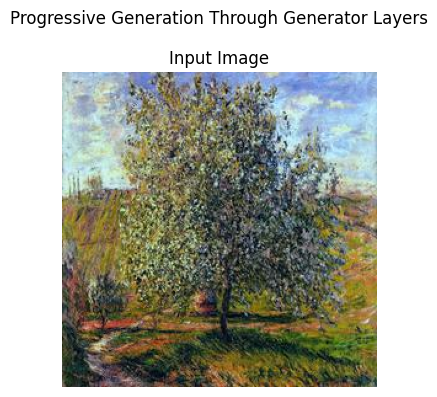


Progression: OR Image → Painting


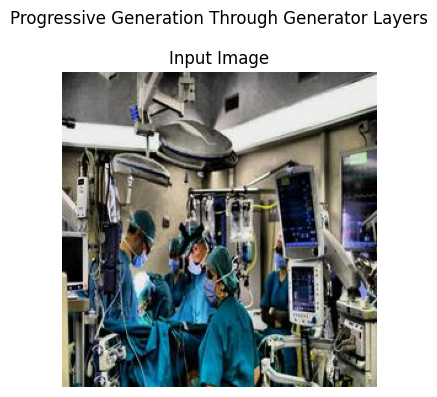

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_progressive_generation(generator, input_image):
    if len(input_image.shape) == 3:
        input_image = tf.expand_dims(input_image, 0)
    
    # Create intermediate models at various depths
    intermediate_models = []
    
    # Find key layers to visualize (downsampling, bottleneck, and upsampling)
    key_indices = []
    bottleneck_found = False
    
    for i, layer in enumerate(generator.layers):
        if i == 0:
            continue
        
        # Look for significant layers like Conv2D, Conv2DTranspose, and Add
        layer_type = layer.__class__.__name__
        if layer_type in ['Conv2D', 'Conv2DTranspose', 'Add']:
            if not bottleneck_found and i > len(generator.layers) // 3:
                bottleneck_found = True
                key_indices.append(i)
            elif i % 4 == 0:  # Looking at roughly every 4th significant layer
                key_indices.append(i)
    
    # Add the final output layer
    key_indices.append(len(generator.layers) - 1)
    
    # Limit to at most 8 layers to avoid overcrowding
    if len(key_indices) > 8:
        # Ensure we keep first, bottleneck, and last
        essential_indices = [key_indices[0], key_indices[len(key_indices)//2], key_indices[-1]]
        remaining = 5  # 8 - 3 essential indices
        
        # Select additional indices evenly distributed
        step = (len(key_indices) - 3) // (remaining + 1)
        selected_indices = []
        
        for i in range(1, remaining + 1):
            idx = i * step
            if idx < len(key_indices) - 1:  # Avoid the last index as it's already in essential_indices
                selected_indices.append(key_indices[idx])
        
        key_indices = sorted(essential_indices + selected_indices)
    
    # Models for each key layer
    for idx in key_indices:
        layer = generator.layers[idx]
        intermediate_model = tf.keras.Model(inputs=generator.input, outputs=layer.output)
        intermediate_models.append((idx, layer.name, intermediate_model))
    
    # Give back intermediate outputs
    intermediate_outputs = []
    for idx, name, model in intermediate_models:
        output = model(input_image)
        intermediate_outputs.append((idx, name, output))
    
    # Plot results
    num_outputs = len(intermediate_outputs)
    rows = int(np.ceil(num_outputs / 4))
    cols = min(num_outputs, 4)
    
    plt.figure(figsize=(16, 4 * rows))
    
    # Function to convert from normalized [-1, 1] to display range [0, 1]
    def denormalize(img):
        if isinstance(img, tf.Tensor):
            img = img.numpy()
        return (img + 1) * 0.5
    
    # Display input image
    plt.subplot(rows, cols, 1)
    plt.imshow(denormalize(input_image[0]))
    plt.title('Input Image')
    plt.axis('off')
    
    # Display intermediate outputs
    for i, (idx, name, output) in enumerate(intermediate_outputs[1:], start=2):
        plt.subplot(rows, cols, i)
        
        # Handle different output shapes
        if len(output.shape) == 4:
            # For feature maps, use the first 3 channels combined as RGB
            if output.shape[-1] > 3:
                # Take first 3 channels
                channels = output[0, :, :, :3]
                # Normalize each channel independently
                channels_normalized = tf.stack([
                    (channels[:, :, i] - tf.reduce_min(channels[:, :, i])) / 
                    (tf.reduce_max(channels[:, :, i]) - tf.reduce_min(channels[:, :, i]) + 1e-7)
                    for i in range(3)
                ], axis=-1)
                plt.imshow(channels_normalized)
            else:
                # If exactly 3 channels, treat as RGB
                plt.imshow(denormalize(output[0]))
        else:
            # For 2D outputs, use grayscale
            plt.imshow(output[0], cmap='gray')
        
        plt.title(f'Layer {idx}: {name}')
        plt.axis('off')
    
    plt.suptitle('Progressive Generation Through Generator Layers')
    plt.tight_layout()
    plt.show()
    
    return intermediate_outputs

# Helper function to create a dataset from image paths
def create_dataset(image_paths, batch_size=1, shuffle=True, img_height=256, img_width=256):
    """Create a TensorFlow dataset from image paths"""
    def preprocess_image(image_file):
        """Load and preprocess an image from file path"""
        image = tf.io.read_file(image_file)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [img_height, img_width])
        image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
        return image
        
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    
    dataset = dataset.batch(batch_size)
    return dataset

# Function to showcase progressive generation for both generators
def show_progressive_generation_demo(generator_g, generator_f, train_paintings_ds, train_or_images_ds):
    # Get sample images
    sample_painting = next(iter(train_paintings_ds))
    sample_or_image = next(iter(train_or_images_ds))
    
    # Show progression for painting to OR image
    print("Progression: Painting → OR Image")
    painting_progression = visualize_progressive_generation(generator_g, sample_painting)
    
    # Show progression for OR image to painting
    print("\nProgression: OR Image → Painting")
    or_progression = visualize_progressive_generation(generator_f, sample_or_image)
    
    return painting_progression, or_progression


# First, create the datasets
train_paintings = [os.path.join("preprocessed_paintings/train", f) for f in os.listdir("preprocessed_paintings/train") if f.endswith('.jpg')]
train_or_images = [os.path.join("preprocessed_or_images/train", f) for f in os.listdir("preprocessed_or_images/train") if f.endswith('.jpg')]

# Create the datasets
train_paintings_ds = create_dataset(train_paintings, batch_size=1)
train_or_images_ds = create_dataset(train_or_images, batch_size=1)

# Now run the visualization
# Assuming generator_g and generator_f are already defined from your training
painting_progression, or_progression = show_progressive_generation_demo(generator_g, generator_f, train_paintings_ds, train_or_images_ds)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

try:
    print("Loading trained models...")
    generator_g = tf.keras.models.load_model('best_generator_g.h5')  
    generator_f = tf.keras.models.load_model('best_generator_f.h5')
    print("Models loaded successfully!")
except Exception as e:
    print(f"Error loading models: {e}")
    print("Make sure you've trained and saved your models first.")
    print("Creating dummy models for testing the visualization...")
    
    def build_dummy_generator():
        inputs = tf.keras.layers.Input(shape=[256, 256, 3])
        # Just a pass-through model for testing
        return tf.keras.models.Model(inputs=inputs, outputs=inputs)
    
    generator_g = build_dummy_generator()
    generator_f = build_dummy_generator()
    print("Dummy models created for testing.")

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.LANCZOS)
    
    img_array = np.array(img)
    img_array = (img_array.astype(np.float32) / 127.5) - 1
    
    img_array = np.expand_dims(img_array, 0)
    
    return img_array

def apply_style_transfer(image_path, generator, output_path=None, style_name=""):
    input_image = load_and_preprocess_image(image_path)
    output_image = generator(input_image)
    output_array = output_image[0].numpy()
    output_array = (output_array * 0.5 + 0.5) * 255
    output_array = np.clip(output_array, 0, 255).astype(np.uint8)
    styled_image = Image.fromarray(output_array)
    
    if output_path:
        styled_image.save(output_path)
        print(f"Styled image saved to {output_path}")
    
    # Display images
    plt.figure(figsize=(12, 6))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(image_path))
    plt.title("Original Image")
    plt.axis('off')
    
    # Styled image
    plt.subplot(1, 2, 2)
    plt.imshow(styled_image)
    plt.title(f"With {style_name} Style")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return styled_image

# Apply style transfer to your own image
your_image_path = '/home/ubuntu/GenAI/OwnPics/IMG_8907.jpeg' #Replace path here

output_dir = "my_styled_images"
os.makedirs(output_dir, exist_ok=True)

# Add OR style to a painting 
output_path_or_style = os.path.join(output_dir, "my_image_with_or_style.jpg")
styled_result1 = apply_style_transfer(
    your_image_path, 
    generator_g, 
    output_path_or_style,
    "OR"
)

# Add painting to OR image
output_path_painting_style = os.path.join(output_dir, "my_image_with_painting_style.jpg")
styled_result2 = apply_style_transfer(
    your_image_path, 
    generator_f, 
    output_path_painting_style,
    "Painting"
)